# Named Entity Recognition

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

## Loading Dataset

In [2]:
from data_utils import create_vocabularies, load_dataset

DATA_PATH = "Data/ner_dataset.csv"

In [3]:
sentences, tags = load_dataset(DATA_PATH)

Total Number of sentences : 47959


### Spliting Data in Train and Test sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(sentences, 
                                                    tags, test_size=0.2)

### Building Vocabularies

In [5]:
UNK_TOKEN = '<unk>'
PAD_WORD_TOKEN = '<pad>'
PAD_TAG_TOKEN = '<pad_tag>'

word_vocab, tag_vocab = create_vocabularies(X_train, y_train)

In [6]:
print(f"Vocabulary size : {len(word_vocab)}")

Vocabulary size : 31985


## Building Data Loading Methods

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [8]:
class NERDataset:
    def __init__(self, vocab_dict, tag_dict, sent_list, tag_list):
        self.vocab = vocab_dict
        self.tags = tag_dict
        
        self.sentences = sent_list
        self.sentence_tags = tag_list
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sent = self.sentences[idx]
        tags = self.sentence_tags[idx]
        
        psent = [self.vocab.get(word, self.vocab[UNK_TOKEN]) for word in sent]
        ptags = [self.tags.get(tag) for tag in tags]
        
        return torch.LongTensor(psent), torch.LongTensor(ptags)

### Batch formation Method

In [9]:
def collate_fn(batch):
    sentences, tags = map(list, zip(*batch))
    max_len = max([len(x) for x in sentences])
    
    bsent = torch.zeros([len(batch), max_len], dtype = torch.long)
    btags = torch.zeros([len(batch), max_len], dtype = torch.long)
    
    for i in range(len(batch)):
        bsent[i, :] = F.pad(sentences[i], (0, max_len - len(sentences[i])), 'constant', word_vocab[PAD_WORD_TOKEN])
        btags[i, :] = F.pad(tags[i], (0, max_len - len(tags[i])), 'constant', tag_vocab[PAD_TAG_TOKEN])
    
    return bsent, btags

In [10]:
train_data = NERDataset(word_vocab, tag_vocab, X_train, y_train)
test_data = NERDataset(word_vocab, tag_vocab, X_test, y_test)

BATCH_SIZE = 32

dl = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Building Model

In [11]:
import torch.nn as nn
import torch.optim as optim

In [12]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, out_size):
        super(LSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size)
        self.output = nn.Linear(hidden_size, out_size)
        self.logSoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        ex = self.embedding(x)
        out, _ = self.lstm(ex)
        out = out.view(-1, out.shape[2])
        out = self.output(out)
        
        return self.logSoftmax(out)

## Essential Parameters

In [13]:
VOCAB_SIZE = len(word_vocab)
OUT_SIZE = len(tag_vocab) - 1
EMB_SIZE = 300
HIDDEN_SIZE = 128
N_EPOCHS = 10
LR = 1e-04

## Loss and Accuracy Functions

In [14]:
def loss_fn(outputs, label):
    label = label.view(-1)
    
    mask = (label >= 0).float()  # Mask for pad tag tokens i.e. -1
    
    label = label % outputs.shape[1] # because indexing with -ve number is 
                                     # not desired
        
    num_tokens = torch.sum(mask)  # number of tokens to be counted in loss
    
    # we have log likelihood, we are calculating NLLL by neglecting Pad tokens
    return -torch.sum(outputs[range(outputs.shape[0]), label] * mask) / num_tokens

def accuracy(outputs, labels):
    labels = labels.ravel()
    
    mask = (labels >= 0)
    
    outputs = np.argmax(outputs, axis = 1)
    
    return np.sum(outputs == labels) / float(np.sum(mask))

In [15]:
net = LSTMNet(VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZE, OUT_SIZE)
opt = optim.Adam(net.parameters(), lr=LR)
net

LSTMNet(
  (embedding): Embedding(31985, 300)
  (lstm): LSTM(300, 128)
  (output): Linear(in_features=128, out_features=17, bias=True)
  (logSoftmax): LogSoftmax()
)

## Running Training Loop

In [16]:
import copy

net = net.cuda()

losses = []
accuracies = []
best_net_accuracy = 0
best_net = copy.deepcopy(net)


for k in range(N_EPOCHS):
    train_l = 0
    train_a = 0
    
    test_l = 0
    test_a = 0
    
    for j, (sbatch, tbatch) in enumerate(dl):
        opt.zero_grad()
        sbatch = sbatch.cuda()
        tbatch = tbatch.cuda()
        out_pred = net(sbatch)
        
        l = loss_fn(out_pred, tbatch)

        l.backward()
        train_l += l.item()
        opt.step()
        
        out = out_pred.data.cpu().numpy()
        tout = tbatch.data.cpu().numpy()
        train_a += accuracy(out, tout)
    print(f"Epoch : {k + 1}")
    print(f"Training Loss : {train_l / j:.3f} Accuracy : {train_a * 100 / j:.3f}")
    
    with torch.no_grad():
        for i, (sbatch, tbatch) in enumerate(test_dl):
            sbatch = sbatch.cuda()
            tbatch = tbatch.cuda()
            
            out_pred = net(sbatch)
            
            l = loss_fn(out_pred, tbatch)
            
            test_l += l.item()
            
            out = out_pred.data.cpu().numpy()
            tout = tbatch.data.cpu().numpy()
            test_a += accuracy(out, tout)
    
    print(f"Testing Loss : {test_l / i:.3f} Accuracy : {test_a * 100 / i:.3f}")
    
    if(best_net_accuracy < test_a * 100 / i):
        print(f"Found new best accuracy : {test_a * 100 / i}")
        best_net_accuracy = test_a * 100 / i
        best_net = copy.deepcopy(net)
    
    losses.append([train_l / j, test_l / i])
    accuracies.append([train_a * 100 / j, test_a * 100 / i])
    
print(f"Best Net Accuracy : {best_net_accuracy}")

Epoch : 1
Training Loss : 0.854 Accuracy : 82.762
Testing Loss : 0.575 Accuracy : 87.405
Found new best accuracy : 87.40451914755974
Epoch : 2
Training Loss : 0.489 Accuracy : 88.837
Testing Loss : 0.434 Accuracy : 90.233
Found new best accuracy : 90.23319775651277
Epoch : 3
Training Loss : 0.386 Accuracy : 90.865
Testing Loss : 0.364 Accuracy : 91.423
Found new best accuracy : 91.42336718912264
Epoch : 4
Training Loss : 0.329 Accuracy : 91.902
Testing Loss : 0.322 Accuracy : 91.722
Found new best accuracy : 91.72209232670932
Epoch : 5
Training Loss : 0.293 Accuracy : 92.531
Testing Loss : 0.295 Accuracy : 92.078
Found new best accuracy : 92.07782697123591
Epoch : 6
Training Loss : 0.267 Accuracy : 93.022
Testing Loss : 0.276 Accuracy : 92.428
Found new best accuracy : 92.42794575396226
Epoch : 7
Training Loss : 0.248 Accuracy : 93.379
Testing Loss : 0.262 Accuracy : 92.704
Found new best accuracy : 92.7040044073748
Epoch : 8
Training Loss : 0.233 Accuracy : 93.673
Testing Loss : 0.251

## Testing

In [17]:
idx2word = dict(zip(word_vocab.values(), word_vocab.keys()))
idx2tag = dict(zip(tag_vocab.values(), tag_vocab.keys()))

## Visualizing Losses and Accuracy

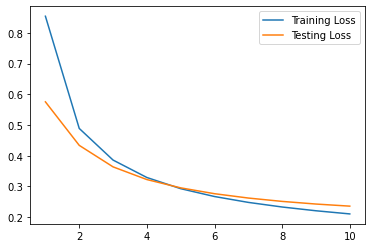

In [18]:
import matplotlib.pyplot as plt

losses = np.array(losses)
accuracies = np.array(accuracies)

plt.plot(range(1, len(losses) + 1), losses[:, 0], label = "Training Loss")
plt.plot(range(1, len(losses) + 1), losses[:, 1], label = "Testing Loss")
plt.legend()

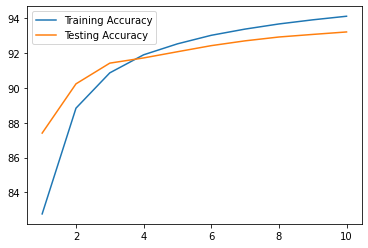

In [19]:
plt.plot(range(1, len(accuracies) + 1), accuracies[:, 0], label = "Training Accuracy")
plt.plot(range(1, len(accuracies) + 1), accuracies[:, 1], label = "Testing Accuracy")
plt.legend()

### Checking model output

In [20]:
out = torch.argmax(out_pred, axis = 1)
out = out.reshape(tbatch.shape[0], -1)

sentences = sbatch[:5].data.cpu().numpy()
labels = tbatch[:5].data.cpu().numpy()
preds = out[:5].data.cpu().numpy()

for i in range(5):
    print("Sentence : {}".format(i + 1))
    sent = sentences[i]
    label = labels[i]
    pred = preds[i]
    
    temp = (label >= 0).sum()
    
    sent = list(map(lambda x: idx2word.get(x, idx2word[1]), sent[:temp]))
    sent = '\t'.join(word for word in sent if word != '<pad>')
    
    label = list(map(lambda x: idx2tag.get(x, idx2tag[-1]), label[:temp]))
    label = '\t'.join(word for word in label if word != '<pad_tag>')
    
    pred = list(map(lambda x: idx2tag.get(x, idx2tag[-1]), pred[:temp]))
    pred = '\t'.join(word for word in pred if word != '<pad_tag>')
    
    print(sent)
    print("Truth Labels")
    print(label)
    print("Predictions")
    print(pred)
    print("\n\n")

Sentence : 1
Merck	withdrew	the	popular	drug	last	year	after	a	study	showed	it	doubled	the	risk	of	heart	problems	in	long-term	users	.
Truth Labels
B-org	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O
Predictions
O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O



Sentence : 2
French	Foreign	Minister	Philippe	Douste-Blazy	said	Friday	he	hopes	Iran	will	hear	the	voice	of	reason	and	not	resume	nuclear	activities	.
Truth Labels
B-org	I-org	O	B-per	I-per	O	B-tim	O	O	B-geo	O	O	O	O	O	O	O	O	O	O	O	O
Predictions
B-gpe	O	O	O	O	O	B-tim	O	O	B-geo	O	O	O	O	O	O	O	O	O	O	O	O



Sentence : 3
Meanwhile	,	China	has	reported	two	new	outbreaks	of	bird	flu	among	poultry	in	the	northeastern	province	of	Liaoning	,	bringing	the	total	number	of	reported	outbreaks	in	the	country	over	the	past	month	to	six	.
Truth Labels
O	O	B-geo	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-geo	O	O	O	O	O	O	O	O	O	O	O	O	O	B-tim	O	B-tim	I-tim	O
Predictions
O	O	B-geo	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	O	B-tim	O	O	O	O



Sentence : 4
Th

## Running on Your sentences

In [21]:
sample = "Las Vegas is the center of gambling in USA and is very crowded in the month of December ."

words = sample.split()
idx_list = [word_vocab.get(word, word_vocab.get(UNK_TOKEN)) for word in words]

x = torch.LongTensor(idx_list)
x = x.unsqueeze(0)

out = best_net(x.cuda())

pred = torch.argmax(out, axis = 1)

pred = pred.data.cpu().numpy()

pred = list(map(lambda x: idx2tag.get(x, idx2tag[-1]), pred))

for i, word in enumerate(words):
    print(f"{word} --> {pred[i]}")

Las --> O
Vegas --> O
is --> O
the --> O
center --> O
of --> O
gambling --> O
in --> O
USA --> O
and --> O
is --> O
very --> O
crowded --> O
in --> O
the --> O
month --> O
of --> O
December --> B-tim
. --> O


..\aten\src\ATen\native\cudnn\RNN.cpp:1269: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
